# Markowitz model and Portfolio efficient frontier
## Shujaat Bakhsh - Mickaël Avril - Kanika Ghocha - December 14, 2018
### FE520 - Intro to Python - Final Project
***

#### 1 - Background

The Modern portfolio theory is a theory on how risk-averse investors can construct portfolios to optimize or
maximize expected return based on a given level of market risk, emphasizing that risk is an inherent part of
higher reward.
Therefore, it is possible to construct an "efficient frontier" of optimal portfolios offering the maximum
possible expected return for a given level of risk.
Harry Markowitz received the nobel price of Economy for developing this model.

#### 2 - Methodology

We selected a group of stocks (10) from the S&P500, we tried to add some sort of diversification by selecting
stocks from each big industries. We will construct a optimal risky portfolio with these stocks by finding the 
weights that will optimize the sharpe ratio we will represent the efficient frontier of this portfolio.

Our plan for the project is to:

1 - Collect monthly closing prices of 10 assets over 5 years.

2 - Compute various metrics like return and volatility over the period.

3 - Construct a variance-covariance table of the stocks.

4 - Calculate return and volatility and sharpe ratio of an equally weighted portfolio.

5 - Optimize the sharpe ratio to obtain an optimal risky portfolio.

6 - Plot the efficient frontier of this portfolio.

In [1]:
import pandas as pd
from pandas import Series,DataFrame
import math
import scipy.stats as stats
import scipy.optimize as sco
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
from datetime import datetime
%matplotlib inline

#### 3 - Return and volatility

In [2]:
pd.options.display.float_format = '{:,.4f}'.format
df = pd.read_csv("Stock_Data_5years.csv")
dates=[]
for i in list(df['Date']):
    a=datetime.strptime(i , '%m/%d/%y')
    dates.append(a.strftime('%b %y'))
df['Date']=dates
#inversing order of display to calculate returns
Stocks=list(df.columns[1:])
df.head(5)

,Date,SPY,ES,EA,V,PFE,C,CTSH,SBUX,COST,BA
0,Nov 18,273.7300,67.0400,85.9700,139.9288,43.1768,64.5060,70.1300,67.7960,230.4722,334.4058
1,Oct 18,270.6300,63.2600,90.9800,137.6030,42.7303,65.0125,68.8337,57.9588,228.0878,353.2289
2,Sep 18,289.4099,60.9398,120.4900,149.8210,43.7325,71.2496,76.9306,56.5364,234.3230,370.1906
3,Aug 18,289.0017,61.9217,113.4100,146.4067,40.8542,70.3098,77.9982,52.7970,232.0013,339.5367
4,Jul 18,280.0622,60.2257,128.7500,136.2901,39.2897,70.9513,81.0513,51.7499,217.6511,352.9184


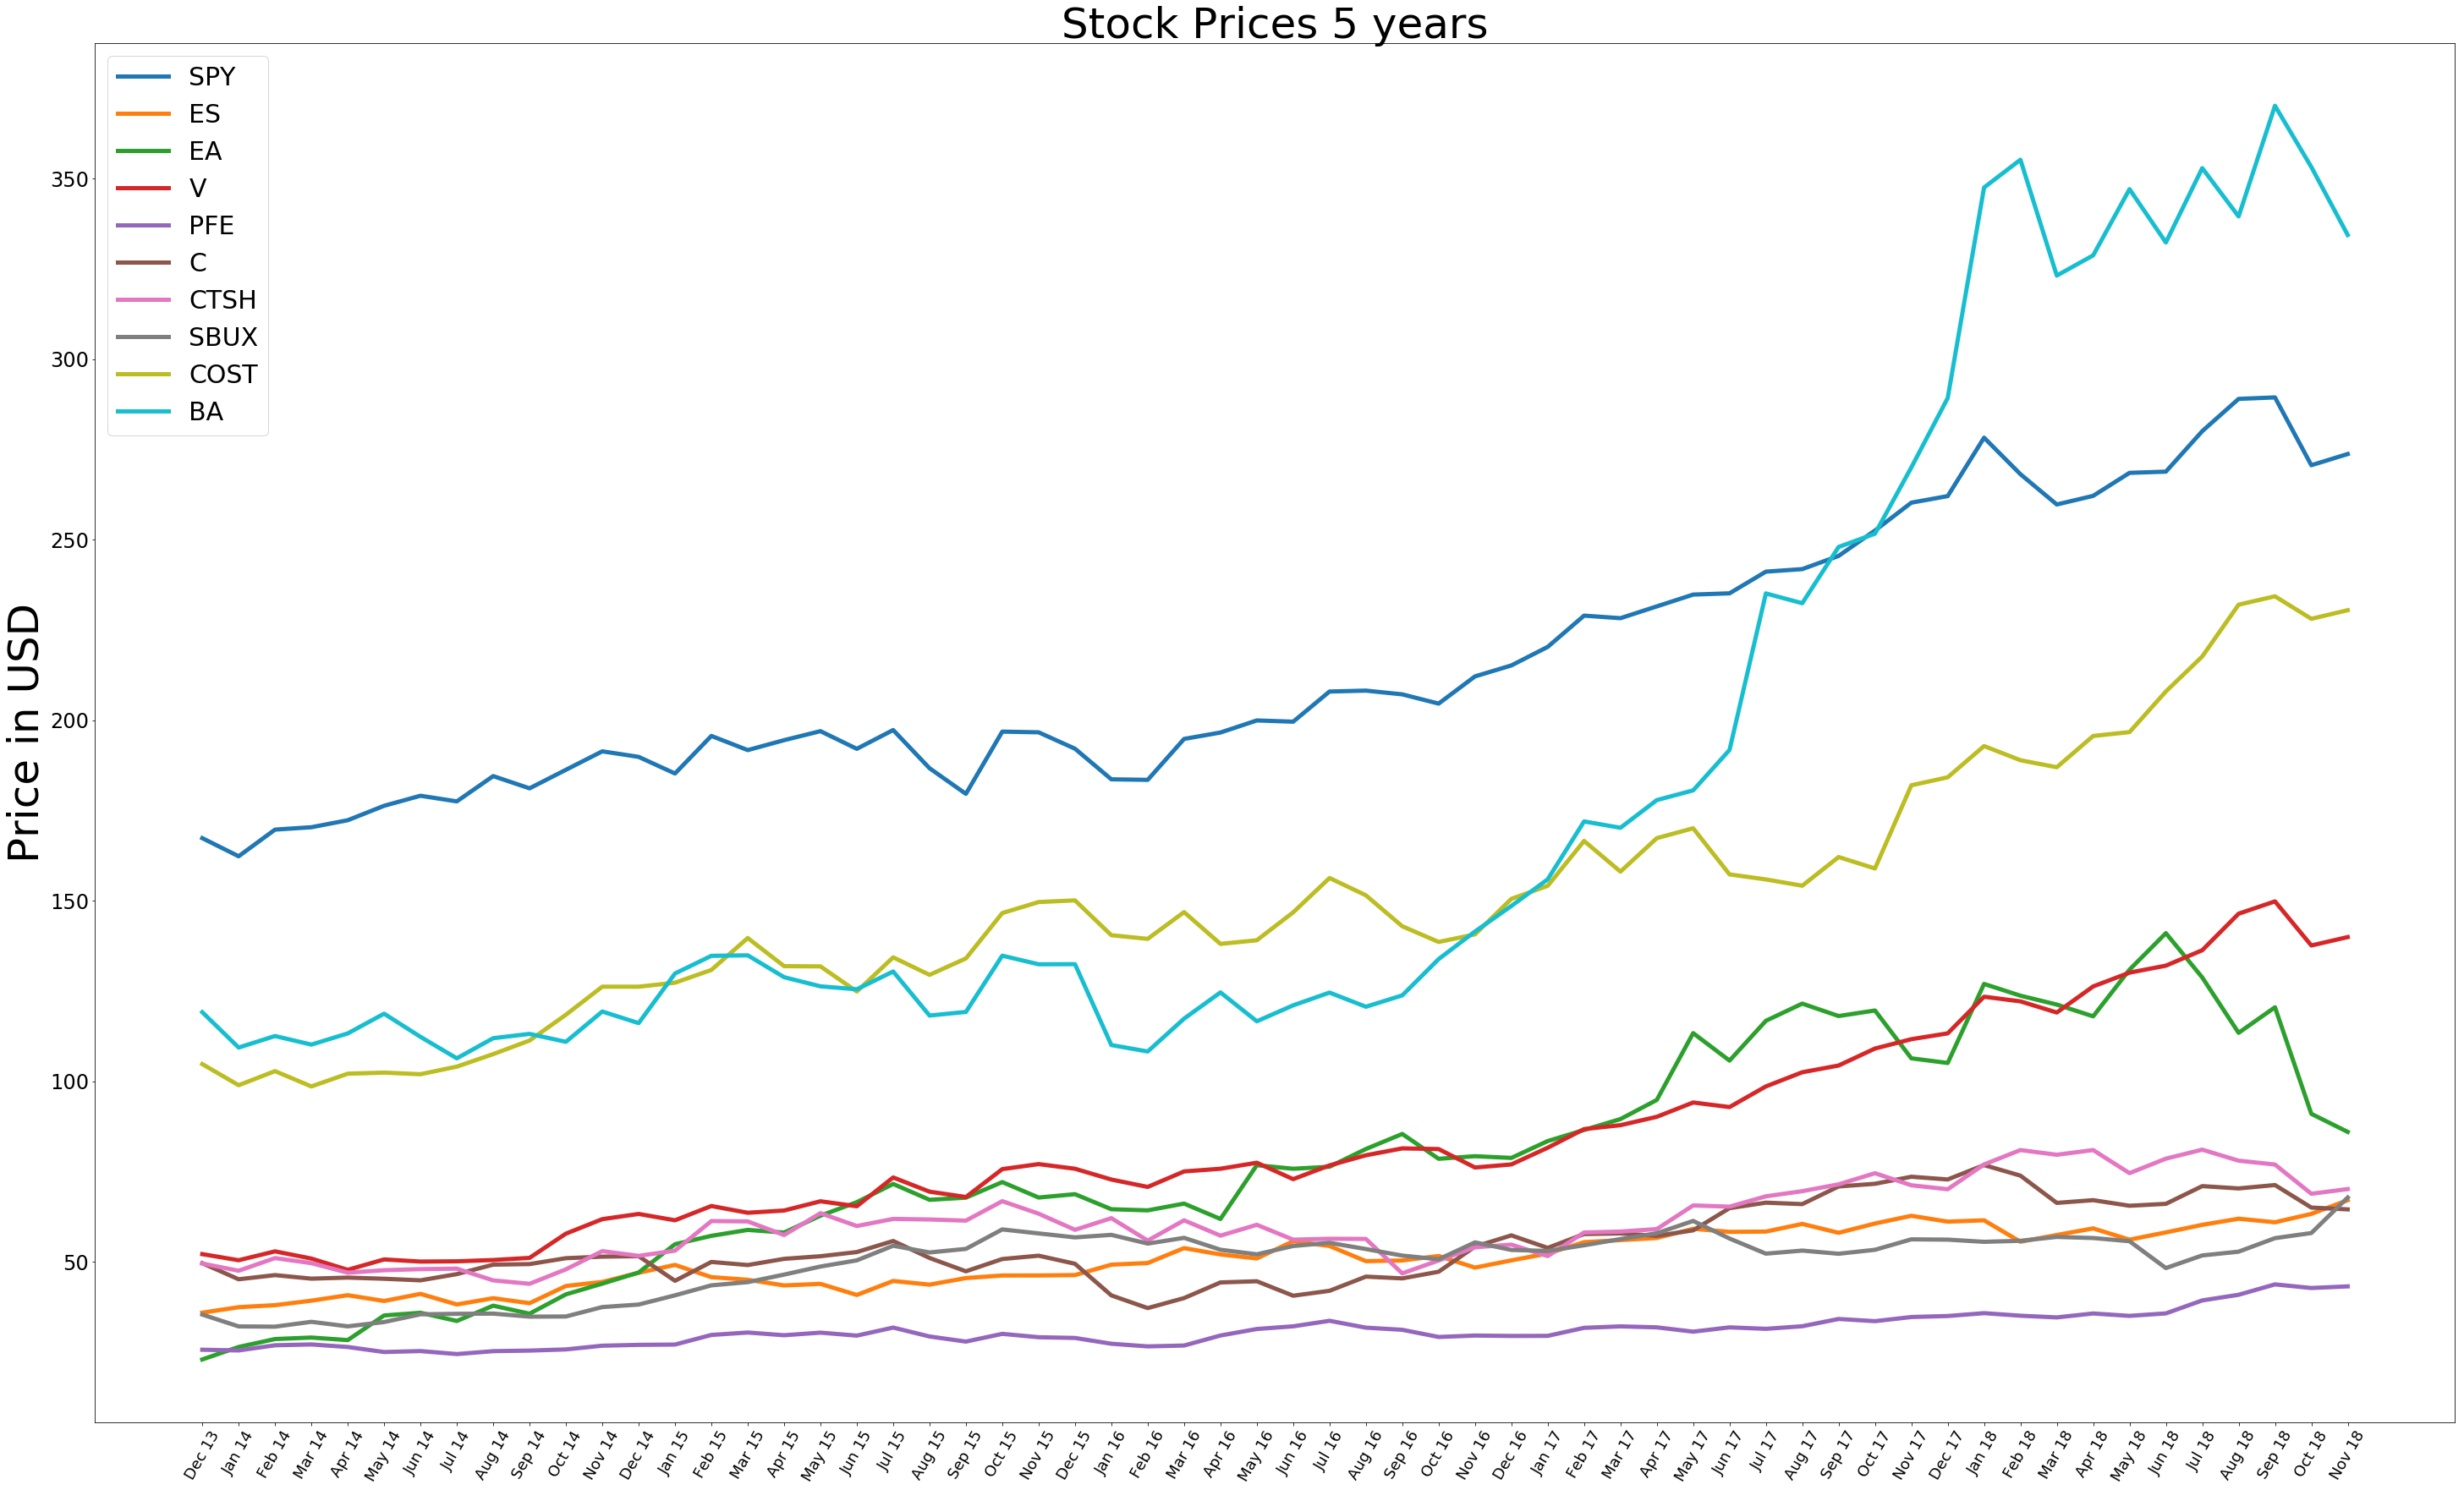

In [3]:
#Plots of time series of 10 assets
plt.figure(figsize=(50,30))
df_plot=df.set_index('Date')
df_plot=df_plot.iloc[::-1]
plt.plot(df_plot,linewidth=5)
plt.title('Stock Prices 5 years',fontsize=50)
plt.xticks(fontsize=18,rotation=60)
plt.yticks(fontsize=24)
plt.ylabel('Price in USD',fontsize=50)
plt.legend(Stocks,loc=2, prop={'size': 30})
plt.show()

In [4]:
# function that displays negative monthly returns on red and positive in green
def color_negative_red(val):
    color = 'red' if val < 0 else 'green'
    return 'color: %s' % color
df_ret=df.set_index('Date')
ret=(df_ret/df_ret.shift(-1))-1
ret=ret[:-1]
ret1=ret*100
ret1=ret1.style.applymap(color_negative_red)
ret1

,SPY,ES,EA,V,PFE,C,CTSH,SBUX,COST,BA
Date,,,,,,,,,,
Nov 18,1.14548,5.97534,-5.50671,1.69023,1.04505,-0.779104,1.88325,16.9727,1.04535,-5.32886
Oct 18,-6.48903,3.80736,-24.4917,-8.1551,-2.29181,-8.75383,-10.525,2.51584,-2.66093,-4.58188
Sep 18,0.141235,-1.58578,6.24283,2.33208,7.0454,1.33662,-1.36869,7.08272,1.00075,9.02816
Aug 18,3.19199,2.81621,-11.9146,7.42285,3.98197,-0.904166,-3.76687,2.02329,6.5932,-3.79174
Jul 18,4.17033,3.60007,-8.7009,3.23897,10.0606,7.42678,3.17761,7.24667,4.65596,6.19653
Jun 18,0.125485,3.58579,7.72286,1.48626,1.95979,0.819747,5.38548,-13.3484,5.72507,-4.2527
May 18,2.43091,-5.26141,10.9595,3.02648,-1.85742,-2.31433,-7.9076,-1.56332,0.547775,5.57621
Apr 18,0.919407,3.16975,-2.68888,6.06921,3.15582,1.14072,1.63975,-0.552772,4.63303,1.73233
Mar 18,-3.12904,3.36842,-1.98868,-2.5311,-1.35282,-10.2214,-1.61189,1.93345,-1.02974,-9.03107


In [6]:
ret.loc['Monthly Avg Return']=ret.mean() # average monthly return
ret.loc['Standard Deviation']=ret.std() # Volatility
ret.loc['Variance']=ret.var() # Variance
ret2=ret.style.apply(lambda x: ['background: lightgreen' if x.name == 'Monthly Avg Return' else 'background: lightblue' if x.name == 'Standard Deviation' else'background: yellow' if x.name == 'Variance' else '' for i in x], 
               axis=1)
ret2

,SPY,ES,EA,V,PFE,C,CTSH,SBUX,COST,BA
Date,,,,,,,,,,
Nov 18,0.0114548,0.0597534,-0.0550671,0.0169023,0.0104505,-0.00779104,0.0188325,0.169727,0.0104535,-0.0532886
Oct 18,-0.0648903,0.0380736,-0.244917,-0.081551,-0.0229181,-0.0875383,-0.10525,0.0251584,-0.0266093,-0.0458188
Sep 18,0.00141235,-0.0158578,0.0624283,0.0233208,0.070454,0.0133662,-0.0136869,0.0708272,0.0100075,0.0902816
Aug 18,0.0319199,0.0281621,-0.119146,0.0742285,0.0398197,-0.00904166,-0.0376687,0.0202329,0.065932,-0.0379174
Jul 18,0.0417033,0.0360007,-0.087009,0.0323897,0.100606,0.0742678,0.0317761,0.0724667,0.0465596,0.0619653
Jun 18,0.00125485,0.0358579,0.0772286,0.0148626,0.0195979,0.00819747,0.0538548,-0.133484,0.0572507,-0.042527
May 18,0.0243091,-0.0526141,0.109595,0.0302648,-0.0185742,-0.0231433,-0.079076,-0.0156332,0.00547775,0.0557621
Apr 18,0.00919407,0.0316975,-0.0268888,0.0606921,0.0315582,0.0114072,0.0163975,-0.00552772,0.0463303,0.0173233
Mar 18,-0.0312904,0.0336842,-0.0198868,-0.025311,-0.0135282,-0.102214,-0.0161189,0.0193345,-0.0102974,-0.0903107


#### 4 - Covariance Table

In [7]:
Cov_mtrx=ret.cov()
Cov_mtrx

,SPY,ES,EA,V,PFE,C,CTSH,SBUX,COST,BA
SPY,0.0009,0.0001,0.0009,0.0009,0.0007,0.0012,0.0008,0.0004,0.0007,0.0011
ES,0.0001,0.0021,0.0002,0.0003,0.0002,-0.0007,0.0003,0.0004,0.0006,-0.0001
EA,0.0009,0.0002,0.0078,0.0016,0.0002,0.0004,0.0019,-0.0001,0.0003,0.0015
V,0.0009,0.0003,0.0016,0.0020,0.0008,0.0013,0.0013,0.0004,0.0009,0.0012
PFE,0.0007,0.0002,0.0002,0.0008,0.0017,0.0013,0.0007,0.0005,0.0008,0.0010
C,0.0012,-0.0007,0.0004,0.0013,0.0013,0.0038,0.0014,0.0003,0.0007,0.0019
CTSH,0.0008,0.0003,0.0019,0.0013,0.0007,0.0014,0.0040,0.0009,0.0009,0.0011
SBUX,0.0004,0.0004,-0.0001,0.0004,0.0005,0.0003,0.0009,0.0025,0.0006,0.0002
COST,0.0007,0.0006,0.0003,0.0009,0.0008,0.0007,0.0009,0.0006,0.0020,0.0011
BA,0.0011,-0.0001,0.0015,0.0012,0.0010,0.0019,0.0011,0.0002,0.0011,0.0044


#### 5 - Equally Weighted Portfolio

In [8]:
rf=2.9/12  # Risk-Free rate = 2.9% Annualized
Eq_tmp=df.columns.values
Eq_tmp=Eq_tmp[1:]
Eq_w=pd.DataFrame(columns=['Stocks'])
Eq_w['Stocks']=Eq_tmp
weights=[10]*len(Stocks)
weights=np.array(weights)
Eq_w['Weights']=weights
Eq_w.at['Total','Weights']=np.sum(Eq_w['Weights'])
Eq_w.at['Total','Stocks']=''
weights=weights/100
Return=Eq_w.at['Return','Weights']=(np.sum((ret.mean()*weights))*12)*100 #annual return of equal weight portfolio
Eq_w.at['Return','Stocks']=''
Std=Eq_w.at['Standard Deviation','Weights']=(np.sqrt(np.dot(weights.T,np.dot(ret.cov()*12,weights))))*100 #sd of equally weighted portfolio
Eq_w.at['Standard Deviation','Stocks']=''
Eq_w.at['Sharpe Ratio','Weights']=(Return-rf)/Std #calculation of Sharpe ratio
Eq_w.at['Sharpe Ratio','Stocks']=''
Eq_w=Eq_w.style.apply(lambda x: ['background: lightgreen' if x.name == 'Return' else 'background: lightblue' if x.name == 'Standard Deviation' else'background: yellow' if x.name == 'Sharpe Ratio' else '' for i in x], 
               axis=1)
Eq_w

,Stocks,Weights
0,SPY,10
1,ES,10
2,EA,10
3,V,10
4,PFE,10
5,C,10
6,CTSH,10
7,SBUX,10
8,COST,10
9,BA,10


In [10]:
prets=[]
pvols=[]
w=[]
for i in range(5000): # Monte-Carlo simulation
    weights=np.random.random(len(Stocks))
    weights/=np.sum(weights)
    a=np.sum(ret.mean()*weights)*12*100
    b=np.sqrt(np.dot(weights.T,np.dot(ret.cov()*12,weights))) * 100
    prets.append(a)
    pvols.append(b)
    w.append([weights,(a-rf)/b])
prets=np.array(prets)
pvols=np.array(pvols)

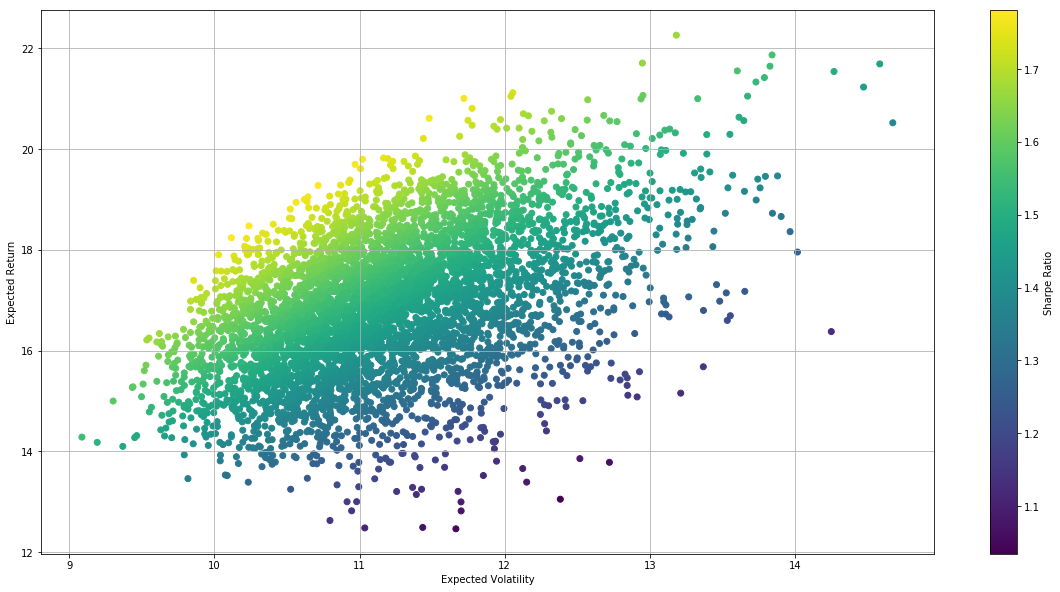

,Stocks,Weights
0,SPY,4.22069
1,ES,26.8529
2,EA,11.4261
3,V,5.78243
4,PFE,8.37329
5,C,0.178941
6,CTSH,0.192004
7,SBUX,11.2135
8,COST,21.0175
9,BA,10.7426


In [11]:
#plotting random portfolio with radom weights
plt.figure(figsize=(20,10))
SharpeRatio=(prets-rf)/pvols
plt.scatter(pvols,prets,c=(prets-rf)/pvols,marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.grid(visible=True)
plt.show()
max_val=max(SharpeRatio)
for i in w : # finding the weights for portfolio with max Sharpe ratio 
    if i[1]==max_val:
        opt_w=i[0]
        break
opt_w=np.array(opt_w)
Eq_tmp=df.columns.values
Eq_tmp=Eq_tmp[1:]
Eq_w=pd.DataFrame(columns=['Stocks'])
Eq_w['Stocks']=Eq_tmp
Eq_w['Weights']=(opt_w*100)
Eq_w.at['Total','Weights']=np.sum(opt_w)*100
Eq_w.at['Total','Stocks']=''
Return=Eq_w.at['Return','Weights']=(np.sum((ret.mean()*opt_w))*12)*100 # return of new portfolio
Eq_w.at['Return','Stocks']=''
Std=Eq_w.at['Standard Deviation','Weights']=(np.sqrt(np.dot(opt_w.T,np.dot(ret.cov()*12,opt_w))))*100 #sd of new portfolio
Eq_w.at['Standard Deviation','Stocks']=''
Eq_w.at['Sharpe Ratio','Weights']=(Return-rf)/Std
Eq_w.at['Sharpe Ratio','Stocks']=''
Eq_w=Eq_w.style.apply(lambda x: ['background: lightgreen' if x.name == 'Return' else 'background: lightblue' if x.name == 'Standard Deviation' else'background: yellow' if x.name == 'Sharpe Ratio' else '' for i in x], 
               axis=1)
Eq_w

#### 6 - Efficient frontier and Capital allocation line

In [12]:
def stats(weights): #function to simplify calling of return, sd, and Sharpe ratio
    weights = np.array(weights)
    prets = np.sum(ret.mean() * weights) *12 *100
    pvols = np.sqrt(np.dot(weights.T, np.dot(ret.cov() *12, weights)))*100
    ShR = (prets-rf)/pvols
    return np.array([prets, pvols, ShR])

In [13]:
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [14]:
def neg_Sharpe(weights): 
    return -stats(weights)[2]

In [15]:
%%time
opt_res=sco.minimize(neg_Sharpe,[.1,]*10,method='SLSQP',bounds=bnds,constraints=cons)

CPU times: user 480 ms, sys: 2.49 ms, total: 483 ms
Wall time: 485 ms


In [16]:
frontier_y=np.linspace(0.0,0.22,50)
frontier_y=frontier_y*100
frontier_y

array([ 0.        ,  0.44897959,  0.89795918,  1.34693878,  1.79591837,
        2.24489796,  2.69387755,  3.14285714,  3.59183673,  4.04081633,
        4.48979592,  4.93877551,  5.3877551 ,  5.83673469,  6.28571429,
        6.73469388,  7.18367347,  7.63265306,  8.08163265,  8.53061224,
        8.97959184,  9.42857143,  9.87755102, 10.32653061, 10.7755102 ,
       11.2244898 , 11.67346939, 12.12244898, 12.57142857, 13.02040816,
       13.46938776, 13.91836735, 14.36734694, 14.81632653, 15.26530612,
       15.71428571, 16.16326531, 16.6122449 , 17.06122449, 17.51020408,
       17.95918367, 18.40816327, 18.85714286, 19.30612245, 19.75510204,
       20.20408163, 20.65306122, 21.10204082, 21.55102041, 22.        ])

In [17]:
def minimize_vol(weights):
    return stats(weights)[1]
frontier_x = []
for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':lambda x: np.sum(x) - 1},
            {'type':'eq', 'fun': lambda w: stats(w)[0] - possible_return})
    
    result = sco.minimize(minimize_vol,[0.1,]*10,method='SLSQP', bounds=bnds, constraints=cons)
    frontier_x.append(result['fun'])

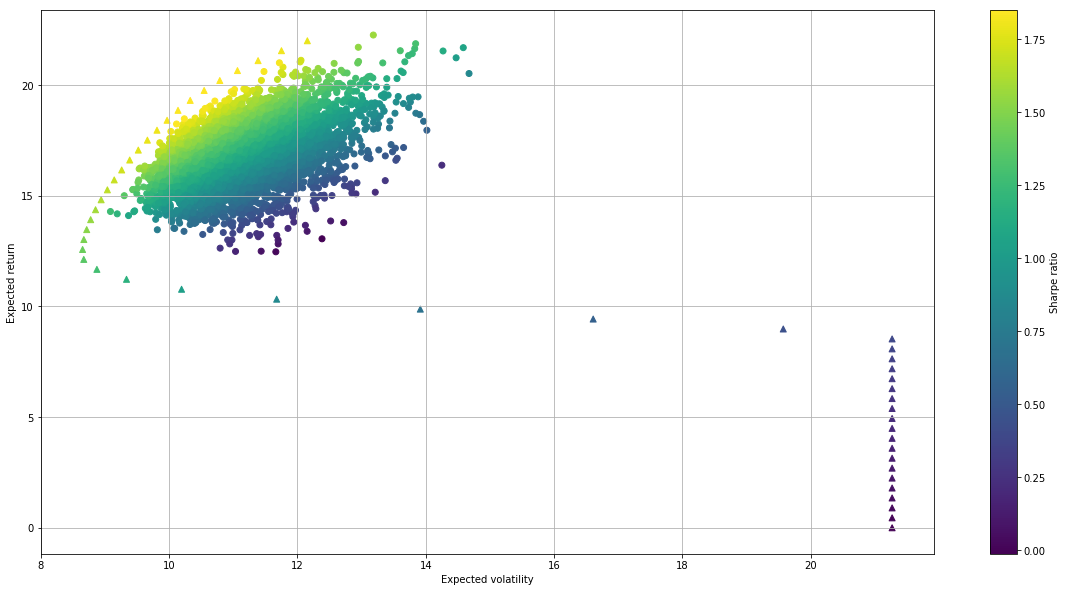

In [18]:
#plot the portfolios along efficient frontier
plt.figure(figsize=(20, 10))
plt.scatter(pvols, prets,
            c=(prets-rf) / pvols, marker='o') #random portfolios
plt.scatter(frontier_x,frontier_y,c=(frontier_y-rf)/frontier_x,marker='^') #efficient frontier
plt.grid(True)
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

# Conclusion
***

We succeeded in finding an optimal risky portfolio.

Next steps would include

   1 - Add an aversion factor in order to mix this portfolio with a risk free asset. The higher the factor the higher the weight in the risk-free asset (w) and the lower in the risky portfolio (w-1)
    
   2 - Compare our result with a Treynor-Black model (implying no covariance matrix but rather a macroeconomic factor)
    
   3 - From the Black-Treynor model, calculate different metrics like Treynor Measure, M-Square, Information ratio, and Alpha.